# Import libraries

We are going to use TPUs for this, since transformers including distilBERT are very heavy duty, and we'll need a lot of computational power for this one.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import DistilBertTokenizer, DistilBertConfig, TFDistilBertModel

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, LSTM, Conv2D, Conv1D, MaxPooling1D, Dense, Dropout, GlobalMaxPooling1D, Input, Bidirectional, concatenate, Flatten, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


# Load data

In [2]:
TRAIN_FILE_PATH = '/kaggle/input/ag-news-classification-dataset/train.csv'
TEST_FILE_PATH = '/kaggle/input/ag-news-classification-dataset/test.csv'


data = pd.read_csv(TRAIN_FILE_PATH)
testdata = pd.read_csv(TEST_FILE_PATH)

X_train = data['Title'] + " " + data['Description']
y_train = data['Class Index'].apply(lambda x: x-1).values # Classes need to begin from 0

x_test = testdata['Title'] + " " + testdata['Description']
y_test = testdata['Class Index'].apply(lambda x: x-1).values # Classes need to begin from 0

maxlen = X_train.map(lambda x: len(x.split())).max()
data.describe()

,Class Index
count,120000.000000
mean,2.500000
std,1.118039
min,1.000000
25%,1.750000
50%,2.500000
75%,3.250000
max,4.000000


# Define tokenizer

In [3]:
vocab_size = 20000
embed_size = 32
distil_bert = 'distilbert-base-uncased'

tokenizer = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=maxlen, pad_to_max_length=True)

def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, pad_to_max_length=True, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

# Tokenize data using defined tokenizer

In [4]:
# Tokenize desc and title train data
X_train = tokenize(X_train, tokenizer)
x_test = tokenize(x_test, tokenizer)

100%|██████████| 7600/7600 [00:14<00:00, 513.91it/s]


# Define model in TPU scope

In [5]:
with tpu_strategy.scope():
    config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
    config.output_hidden_states = False
    transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config=config)

    input_ids_in = tf.keras.layers.Input(shape=(maxlen,), name='input_token', dtype='int32')
    input_masks_in = tf.keras.layers.Input(shape=(maxlen,), name='masked_token', dtype='int32') 

    embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
    X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embedding_layer)
    X = tf.keras.layers.GlobalMaxPool1D()(X)
    X = tf.keras.layers.Dense(64, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    X = tf.keras.layers.Dense(4, activation='sigmoid')(X)
    model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

    for layer in model.layers[:3]:
        layer.trainable = False

    model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 177)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 177)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 177, 768),)  66362880    input_token[0][0]                
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 177, 128)     426496      tf_distil_bert_model[0][0]       
_____________________________________________________________________________________________

# Compile and fit model

In [6]:
callbacks = [
#     EarlyStopping(
#         monitor='val_accuracy',
#         min_delta=1e-4,
#         patience=4,
#         verbose=1
#     ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [7]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=1024, validation_data=(x_test, y_test), epochs=20, callbacks=callbacks)

Epoch 1/20
118/118 [==============================] - ETA: 0s - loss: 0.4139 - accuracy: 0.8734
Epoch 00001: val_accuracy improved from -inf to 0.90868, saving model to weights.h5
118/118 [==============================] - 48s 406ms/step - loss: 0.4139 - accuracy: 0.8734 - val_loss: 0.2627 - val_accuracy: 0.9087
Epoch 2/20
118/118 [==============================] - ETA: 0s - loss: 0.2671 - accuracy: 0.9068
Epoch 00002: val_accuracy improved from 0.90868 to 0.91987, saving model to weights.h5
118/118 [==============================] - 23s 194ms/step - loss: 0.2671 - accuracy: 0.9068 - val_loss: 0.2267 - val_accuracy: 0.9199
Epoch 3/20
118/118 [==============================] - ETA: 0s - loss: 0.2339 - accuracy: 0.9173
Epoch 00003: val_accuracy improved from 0.91987 to 0.92408, saving model to weights.h5
118/118 [==============================] - 22s 190ms/step - loss: 0.2339 - accuracy: 0.9173 - val_loss: 0.2136 - val_accuracy: 0.9241
Epoch 4/20
118/118 [==============================] 

In [8]:
model.load_weights('weights.h5')

# Test model with some arbitrary data

In [9]:
labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']

test = ['New evidence of virus risks from wildlife trade', 'Coronavirus: Bank pumps £100bn into UK economy to aid recovery', 
        'Trump\'s bid to end Obama-era immigration policy ruled unlawful', 'David Luiz’s future with Arsenal to be decided this week']
test_seq = tokenize(test, tokenizer)
test_preds = [labels[np.argmax(i)] for i in model.predict(test_seq)]

for news, label in zip(test, test_preds):
    print('{} - {}'.format(news, label))

100%|██████████| 4/4 [00:00<00:00, 1522.16it/s]


New evidence of virus risks from wildlife trade - Science-Technology News
Coronavirus: Bank pumps £100bn into UK economy to aid recovery - Business News
Trump's bid to end Obama-era immigration policy ruled unlawful - Business News
David Luiz’s future with Arsenal to be decided this week - Business News


# Plot confusion matrix

<Figure size 432x288 with 0 Axes>

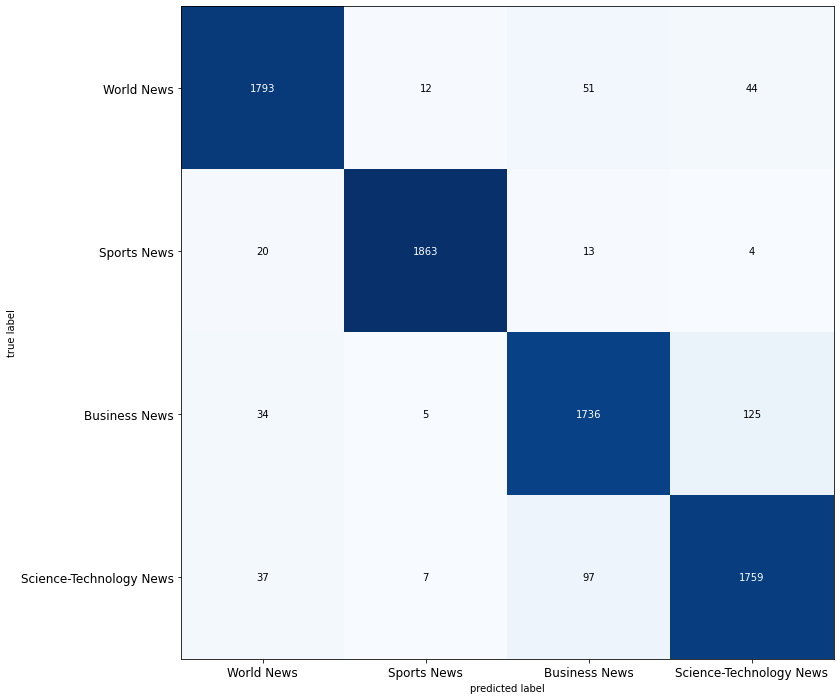

In [10]:
preds = [np.argmax(i) for i in model.predict(x_test)]
cm  = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(16,12), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(4), labels, fontsize=12)
plt.yticks(range(4), labels, fontsize=12)
plt.show()

# Get precision and recall scores

In [11]:
print("Recall of the model is {:.2f}".format(recall_score(y_test, preds, average='micro')))
print("Precision of the model is {:.2f}".format(precision_score(y_test, preds, average='micro')))

Recall of the model is 0.94
Precision of the model is 0.94
